# Проведение А/А/В-тестирования

## Содержание
- 1. Загрузка данных
- 2. Подготовка данных к анализу
- 3. Изучение данных
- 4. Изучение воронки событий
- 5. Изучение результатов A/A/B-эксперимента
- 6. Выводы

### Описание проекта

Стартап заказчика занимается продажей продуктов питания. Нужно разобраться, как ведут себя пользователи его мобильного приложения.

**Цели и задачи исследования**: 

**1. Изучить воронку продаж и узнать:** 
- как пользователи доходят до покупки;
- сколько пользователей доходит до покупки;
- сколько пользователей «застревает» на предыдущих шагах и на каких именно.

**2. Исследовать результаты A/A/B-теста.**

В приложении проведен A/A/B-эксперимент по замене шрифтов по предложению дизайнеров. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт оказался лучше по результатам A/A/B-теста.

**Работа пройдет в несколько этапов:**
1. Загрузим данных и подготовим их к анализу.
2. Проанализируем данные и изучим воронку продаж.
3. Проанализируем результаты A/A/B-эксперимента и проверим, повлияло ли изменение шрифта на поведение пользователей.
4. На основе полученных данных сделаем выводы и дадим рекомендации по улучшению приложения.

## 1. Загрузка данных

In [1]:
#загрузим нужные библиотеки и функции
import os
import warnings
import requests
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
pd.options.display.max_colwidth = 100
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth
from cmath import sqrt

Загрузим данные о поведении пользователей мобильного приложения покупки продуктов питания:

 -   `/logs_exp.csv`

Прочитаем файл из папки, в которой он хранится, и сохраним его:

In [2]:
files = ['logs_exp']
       
for name in files:
    pth1 = '/Users/taisiia.prokhorova/Documents/Яндекс/проекты/project-2/' + str(name) + '.csv'
    pth2 = '/datasets/' + str(name) + '.csv'
    if os.path.exists(pth1):
        df = pd.read_csv(pth1, sep='\t')
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2, sep='\t')
    else:
        print('Something is wrong')

Выведем на экран общую информацию о таблице и первые 5 строк:

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#проверим количество пропусков
display(df.isna().sum())

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Пропущенных данных в таблице нет. В таблице 4 столбца - текстовые имеют формат `object`, числовые `int`. При этом ячейки, содержащие информацию о дате и времени также имеют формат `int` - это нужно будет исправить.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие:
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Теперь приведем данные в нужный формат и подготвим к анализу.

## 2. Подготовка данных к анализу

Проверим наличие дубликатов в таблице:

In [5]:
#проверим количество дубликатов
print(f'Количество дубликатов в таблице:', df.duplicated().sum()) 

Количество дубликатов в таблице: 413


В таблице 413 строк дублируются. Удалим их:

In [6]:
#удалим дубликаты строк, перепишем индексы
df = df.drop_duplicates().reset_index(drop=True)

Заменим названия столбцов в соответствии с принятыми правилами:

In [7]:
#назначим новые названия столбцов
df.columns = ['event_name', 'device_id', 'event_timestamp', 'group']

Переведем столбец с датой в нужный формат `datetime`:

In [8]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

Добавим столбцы даты и времени, а также отдельный столбец с датой:

In [9]:
#добавим столбец с датой
df['date'] = df['event_timestamp'].dt.date

In [10]:
#добавим столбец со временем
df['time'] = df['event_timestamp'].dt.time

In [11]:
#добавим столбец с днем
df['day'] = pd.DatetimeIndex(df['event_timestamp']).day

Проверим результат:

In [12]:
#выведем общую информацию о таблице и первые 5 строк
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id        243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   group            243713 non-null  int64         
 4   date             243713 non-null  object        
 5   time             243713 non-null  object        
 6   day              243713 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.0+ MB


,event_name,device_id,event_timestamp,group,date,time,day
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36,25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42,25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47,25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47,25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42,25


Мы проверили наличие в таблице пустых ячеек, удалили дубликаты. Привели данные во всех столбцах к нужному формату. Добавили столбцы с интересующими нас данными.

Теперь изучим подробнее содержание данных в таблице. 

## 3. Изучение данных

**Проверим, сколько всего событий в логе:**

In [13]:
#посчитаем общее количество строк в таблице
df['event_name'].count()

243713

В таблице информация о 243713 действиях пользователей. Посмотрим, как они распределяются по событиям:

In [14]:
#посчитаем количество строк для каждого события
display(df['event_name'].value_counts())

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Итак, в таблице данные о 5 событиях:

- `MainScreenAppear`	- Главный экран
- `OffersScreenAppear`	- Экран предложений
-	`CartScreenAppear`	- Экран корзины
-	`PaymentScreenSuccessful` - Оплата прошла успешно
-	`Tutorial` - Руководство

При этом количество действий по каждому событию распределено не равномерно. Больше всего пользователи заходили на главный экран, а меньше всего - читали руководство.

**Проверим, сколько всего пользователей в логе:**

In [15]:
#посчитаем количество уникальных устройств
df['device_id'].nunique()

7551

В таблице 7551 уникальный пользователь.

**Посмотрим, сколько в среднем событий приходится на одного пользователя**

In [16]:
#разделим общее количество событий на число уникальных пользователей 
df['event_name'].count() / df['device_id'].nunique()

32.27559263673685

Один пользователь в среднем совершил 32 действия в приложении за рассматриваемый период. Найдем медиану событий на одного пользователя:

In [17]:
#сгруппируем количество событий на каждого пользователя и найдем медиану значений
df.groupby('device_id').agg({'device_id':['count']}).median()

device_id  count    20.0
dtype: float64

Мединнаое количество событий - 20. Медиана меньше, чем среднее, это значит, что в выборке есть выбросы с пользователями, которые совершили аномально большое количество событий. Посмотрим, в каком диапазоне находятся эти значения: 

In [18]:
#найдем минимальное количество событий
df.groupby('device_id').agg({'device_id':['count']}).min()

device_id  count    1
dtype: int64

In [19]:
#найдем максимальное количество событий
df.groupby('device_id').agg({'device_id':['count']}).max()

device_id  count    2307
dtype: int64

Минимальное количество событий на одного пользователя - 1. Скорее всего, пользователь только открыл главный экран приложения. Максимальное - 2306. Какой-то пользователь был чрезвычайно активен.

**Посмотрим, за какой период представлены данные: найдем максимальную и минимальную дату:**

In [20]:
#определим минимальную дату
df['date'].min()

datetime.date(2019, 7, 25)

In [21]:
#определим максимальную дату
df['date'].max()

datetime.date(2019, 8, 7)

В таблице есть данные с 25 июля 2019 г. по 7 августа 2019 г. 

**Построим гистограмму по дате и времени, чтобы проверить, как распределяются данные за период наблюдения:** 

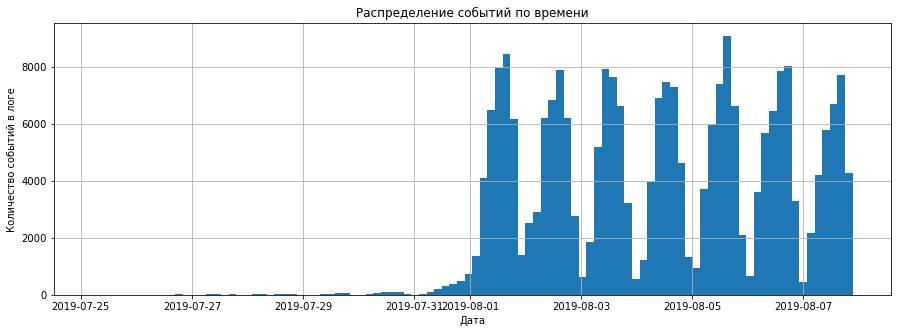

In [22]:
#построим гистограмму 
plt.figure(figsize=(15, 5)) 
df['event_timestamp'].hist(bins=100) 
plt.xlabel('Дата')
plt.ylabel('Количество событий в логе')
plt.title('Распределение событий по времени')
plt.show()

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Как мы видим, до 1 августа 2019 г. у нас есть только отрывочные «старые» данные. 

Полные данные есть только за период с 1 по 7 августа 2019 г. Выделим эти данные в новый датасет:

In [23]:
#сохраним в новую переменную данные после 01.08.2019 включительно
df_2 = df[df['date'] >= datetime.date(2019,8,1)]

Проверим, много ли событий и пользователей мы потеряли, отбросив старые данные:

In [24]:
#сохраним в новую переменную данные до 01.08.2019
df_old = df[df['date'] < datetime.date(2019,8,1)]

In [25]:
#посчитаем количество отброшенных событий и уникальных пользователей
print(f'Отброшено событий:', df_old['event_name'].count())
print(f'Отброшено пользователей:', df_old['device_id'].nunique())

Отброшено событий: 2826
Отброшено пользователей: 1451


Мы отбросили 2826 событий из 243713 (1,1%). Проверим, сколько уникальных пользователей мы удалили полностью:

In [26]:
#проверим наличие id отброшенных пользователей в оставшихся данных
#найдем id пользователей, которых нет в оставшихся данных
unique_old = 0
for old_id in df_old['device_id'].unique():
    if old_id not in df_2['device_id'].unique():
        unique_old = unique_old + 1
print('Количество уникальных старых пользователей:', unique_old)

Количество уникальных старых пользователей: 17


In [27]:
print('Количество уникальных пользователей:', df_2['device_id'].nunique())

Количество уникальных пользователей: 7534


Из 1451 пользователей, данные о которых до 1 августа 2019 г. мы удалили, всего по 17 (меньше 1%) есть данные только за старый период. Остальные пользователи совершали действия и после 1 августа 2019 г.

**Проверим количество пользователей в каждой из групп:**

In [28]:
#сгруппируем данные по группам и вычислим количество уникальных пользователей и количество событий для каждо
df_2.groupby('group').agg({'device_id':['nunique', 'count']}).reset_index()

group device_id       
          nunique  count
0   246      2484  79302
1   247      2513  77022
2   248      2537  84563

Посмотрим, не попали ли одни и те же пользователи в разные группы:

In [29]:
#проверим пересечение id пользователей между группами
df_2.groupby('device_id')['group'].nunique()[df_2.groupby('device_id')['group'].nunique() > 1]

Series([], Name: group, dtype: int64)

Дубликатов пользователей между экспериментальными группами нет, значит, потоки пользователей для групп А/А/В разделены корректно.  

Итак, у нас остались данные по поведению пользователей в мобильном приложении:
- с 1 по 7 августа 2019 г.
- по 7534 уникальным пользователям, которые разделены на 3 экспериментальные группы.

Изучим воронку событий, которую проходят пользователи.

## 4. Изучение воронки событий

**Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.**

In [30]:
#посчитаем, как часто встречается каждое событие 
display(df_2['event_name'].value_counts())

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Чаще всего встречается событие MainScreenAppear - "Главный экран" - 117328 раз. Это логично, чтобы совершить какое-либо действие в приложении, нужно для начала зайти на главный экран.

**Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.**

In [31]:
#посчитаем, сколько уникальных пользователей совершали каждое событие и сколько раз совершали событие
#отсортируем события по частоте
events = df_2.groupby('event_name', as_index=False).agg({'device_id':['nunique','count']})
events.columns = ['event_name', 'unique_users', 'event_count']
events = events.sort_values(by='unique_users', ascending=False).reset_index(drop=True)
display(events)

,event_name,unique_users,event_count
0,MainScreenAppear,7419,117328
1,OffersScreenAppear,4593,46333
2,CartScreenAppear,3734,42303
3,PaymentScreenSuccessful,3539,33918
4,Tutorial,840,1005


Больше всего пользователей также совершили событие MainScreenAppear - "Главный экран" - 7419 человек. 

**Посчитаем долю пользователей, которые хоть раз совершали событие.**

In [32]:
#посчитаем количество уникальных пользователей
print(f'Количество уникальных пользователей:',df_2['device_id'].nunique())

Количество уникальных пользователей: 7534


Количество уникальных пользователей (7534) больше, чем количество уникальных пользователей, которые заходили на главных экран. Проверим, что это за пользователи:

In [33]:
#создадим список из уникальных событий для пользователя 
#выберем из списка пользователей, которые не заходили на главный экран
event_list = df_2.groupby('device_id')['event_name'].unique().reset_index().rename(columns={'event_name': 'event_list'})
strange_list = event_list[event_list['event_list'].apply(lambda x: 'MainScreenAppear' not in x)]['device_id']
strange_list.head()

54      74158328448226259
86     111394506613435756
160    214966247576341063
196    261817378841141406
248    332529825412858125
Name: device_id, dtype: int64

In [34]:
#посчитаем, сколько пользователей в списке
strange_list.count()

115

Всего 115 уникальных пользователей не заходили на главный экран. Посмотрим, какие события они совершали.

In [35]:
display(df_2.query('device_id in @strange_list').head(10))

,event_name,device_id,event_timestamp,group,date,time,day
3221,PaymentScreenSuccessful,5322240575085479425,2019-08-01 01:55:25,246,2019-08-01,01:55:25,1
3222,CartScreenAppear,5322240575085479425,2019-08-01 01:55:25,246,2019-08-01,01:55:25,1
3255,OffersScreenAppear,3187166762535343300,2019-08-01 02:01:30,247,2019-08-01,02:01:30,1
3323,OffersScreenAppear,5322240575085479425,2019-08-01 02:15:50,246,2019-08-01,02:15:50,1
3332,OffersScreenAppear,5322240575085479425,2019-08-01 02:16:58,246,2019-08-01,02:16:58,1
3333,OffersScreenAppear,5322240575085479425,2019-08-01 02:17:04,246,2019-08-01,02:17:04,1
3368,PaymentScreenSuccessful,2485641541735752193,2019-08-01 02:22:20,247,2019-08-01,02:22:20,1
3369,CartScreenAppear,2485641541735752193,2019-08-01 02:22:21,247,2019-08-01,02:22:21,1
3373,OffersScreenAppear,6054246013759836289,2019-08-01 02:23:15,247,2019-08-01,02:23:15,1
3385,OffersScreenAppear,2485641541735752193,2019-08-01 02:24:39,247,2019-08-01,02:24:39,1


In [36]:
#посмотрим, какие события совершали пользователи
display(df_2.query('device_id in @strange_list')['event_name'].value_counts())

OffersScreenAppear         948
CartScreenAppear           909
PaymentScreenSuccessful    747
Tutorial                     7
Name: event_name, dtype: int64

In [37]:
#посмотрим, к каким группам относятся странные пользователи
display(df_2.query('device_id in @strange_list')['group'].value_counts())

248    931
247    874
246    806
Name: group, dtype: int64

Эти пользователи совершали все типы событий, кроме захода на главный экран. Странные пользователи есть во всех группах, однако в группе 248 (экспериментальной) их больше.

Посмотрим, в какие даты действовали пользователи:

In [38]:
#посмотрим, в какие даты действовали пользователи
display(df_2.query('device_id in @strange_list')['date'].value_counts())

2019-08-01    460
2019-08-04    446
2019-08-07    371
2019-08-03    356
2019-08-02    349
2019-08-05    324
2019-08-06    305
Name: date, dtype: int64

Можно было бы предположить, что для некоторых пользователей нет данных по просмотру главного экрана, поскольку они зашли на него еще 31 июля 2019 г., данные за которое мы обрезали. Однако такие пользователи довольно равномерно появляются каждый день наблюдений. 

***Это может быть вызвано двумя причинами:***

1) Возможностью зайти на экран предложений, минуя главный экран (при наличии технической возможности). Допустим, многократным вызовом приложения, находящегося в режиме ожидания, при выборе продуктов для доставки. Пользователь не закрывает приложение, а переводит его в режим ожидания, и повторный вывоз приложения считывается как новое событие.

2) Техническим сбоем при сборе или передаче данных, если при каждой вызове приложения открывается сначала главный экран, а затем уже какой-либо другой.

Поскольку в данной работе мы не знаем технические особенности приложения, будем считать, что действует вариант 1.

**Посчитаем долю пользователей, которые хоть раз совершали событие:**

In [39]:
#разделим количество пользователей, которые совершали каждое событие на общее количество уникальных пользователей
events['all_users_ratio'] = round(events['unique_users'] / df_2['device_id'].nunique() * 100, 2)
display(events)

,event_name,unique_users,event_count,all_users_ratio
0,MainScreenAppear,7419,117328,98.47
1,OffersScreenAppear,4593,46333,60.96
2,CartScreenAppear,3734,42303,49.56
3,PaymentScreenSuccessful,3539,33918,46.97
4,Tutorial,840,1005,11.15


События происходят в следующем порядке: 

1. `MainScreenAppear`	- Главный экран
2. `OffersScreenAppear`	- Экран предложений
3.	`CartScreenAppear`	- Экран корзины
4.	`PaymentScreenSuccessful` - Оплата прошла успешно

Событие `Tutorial` (Руководство) не входит в эту цепочку. Пользователь может прочитать руководство в любой возможный момент или не читать его вовсе. Это событие мы не будем учитывать при расчете воронки.

In [40]:
#удалим событие, которое не входит в воронку событий пользователя
events = events.drop(index=4)
display(events)

,event_name,unique_users,event_count,all_users_ratio
0,MainScreenAppear,7419,117328,98.47
1,OffersScreenAppear,4593,46333,60.96
2,CartScreenAppear,3734,42303,49.56
3,PaymentScreenSuccessful,3539,33918,46.97


**По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).** 

То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [41]:
#для расчета создадим лист с количеством уникальных пользователей для каждого события
#продублируем в листе количество пользователей по первому событию 
#удалим количество пользователей по последнему событию
users_list = list(events['unique_users'].unique())
users_list.insert(0,users_list[0])
users_list.pop(-1)
print(users_list)

[7419, 7419, 4593, 3734]


In [42]:
#рассчитаем долю пользователей, которые совершили следующее событие, от количества тех, кто совершил предыдущее
events['user_step_ratio'] = round(events['unique_users'].div(users_list, axis=0)*100, 2)
display(events)

,event_name,unique_users,event_count,all_users_ratio,user_step_ratio
0,MainScreenAppear,7419,117328,98.47,100.00
1,OffersScreenAppear,4593,46333,60.96,61.91
2,CartScreenAppear,3734,42303,49.56,81.30
3,PaymentScreenSuccessful,3539,33918,46.97,94.78


**Визуализируем данные в виде воронки событий:**

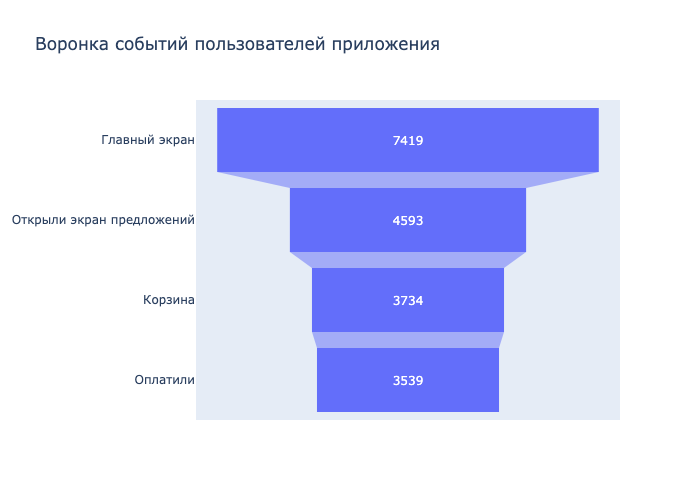

In [43]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Главный экран',
            'Открыли экран предложений',
            'Корзина',
            'Оплатили',
        ],
        x=events.unique_users.unique(),
    )
)

fig.update_layout(
    title="Воронка событий пользователей приложения",
)

fig.show("png") 

**Посмотрим, каком шаге мы теряем больше всего пользователей**


Больше всего пользователей (почти 40%) теряется на шаге 2 "Открыт экран предложений". Это большая цифра. Значит, 40% пользователей, которые заходят на главную страницу, не проходят дальше. 
Это может быть связано как с техническими проблемами (приложение вылетает), так и неудобным интерфейсом (пользователи не могут разобраться, как сделать заказ, и не проходят дальше главного экрана).

**Посмотрим, какая доля пользователей доходит от первого события до оплаты**

47,7% пользователей, которые зашли на главный экран, совершили успешную оплату заказа. Это довольно хороший показатель. Значит, половина пользователей, которые зашли в приложение, сделали заказ.

## 5. Изучение результатов A/A/B-эксперимента

Дизайнеры заказчика предложили поменять шрифты во всём приложении, однако менеджеры заказчика опасались, что пользователям будет непривычно. По итогу договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами (246 и 247) и одну экспериментальную (248) — с новыми. Выясним, какой шрифт лучше по результатам A/A/B-эксперимента. 

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

**Посмотрим, сколько пользователей в каждой экспериментальной группе**

In [44]:
#сгруппируем данные по группам и вычислим количество уникальных пользователей и количество событий для каждой группы
df_2.groupby('group').agg({'device_id':['nunique', 'count']}).reset_index()

group device_id       
          nunique  count
0   246      2484  79302
1   247      2513  77022
2   248      2537  84563

**Проверим, находят ли статистические критерии разницу между выборками 246 и 247.**

In [45]:
# проверим разницу между количеством пользователей в разных группах
r = round((2513 / 2484 - 1)*100, 2)
print(f'Разница между количеством пользователей в группах: {r} %')

Разница между количеством пользователей в группах: 1.17 %


В каждой из групп схожее количество пользователей: в группе 246 2484 пользователей, в группе 247 2513 пользователей, в группе 248 2537 пользователей. 

Группы 246 и 247 - это 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. 

Разница между количеством уникальных пользователей в контрольных группах 1,2%. Это приемлемое значение при проведении тестирования, однако лучше, чтобы разница между группами была не больше 1%. 

**Посчитаем число и долю пользователей, совершивших каждое событие в каждой из контрольных групп. Проверим, будет ли отличие между группами статистически достоверным.**

Посчитаем число пользователей, совершивших каждое событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. 

In [46]:
#создадим для каждой группы сводную таблицу с количеством уникальных пользователей и общим количеством событий
#посчитаем долю пользователей, которые совершили событие от общего числа уникальных пользователей
#посчитаем долю пользователей, которые совершили событие от тех, кто совершил предыдущее событие

events = {}
for i in df_2['group'].unique():
    events[i] = df_2[df_2['group'] == i].pivot_table(
    index=['event_name'],
    values = 'device_id', aggfunc = ['nunique','count']
).reset_index()
    events[i].columns = ['event_name', 'unique_users', 'event_count']
    events[i] = events[i].sort_values(by='unique_users', ascending=False).reset_index(drop=True)
    events[i]['all_users_ratio'] = round(events[i]['unique_users'] / df_2[df_2['group'] == i]['device_id'].nunique() * 100, 2)
    users_list = list(events[i].unique_users.unique())
    users_list.insert(0,users_list[0])
    users_list.pop(-1)
    events[i]['user_step_ratio'] = round(events[i]['unique_users'].div(users_list, axis=0)*100, 2)

    print(i)
    display(events[i])

246


,event_name,unique_users,event_count,all_users_ratio,user_step_ratio
0,MainScreenAppear,2450,37676,98.63,100.00
1,OffersScreenAppear,1542,14767,62.08,62.94
2,CartScreenAppear,1266,14690,50.97,82.10
3,PaymentScreenSuccessful,1200,11852,48.31,94.79
4,Tutorial,278,317,11.19,23.17


247


,event_name,unique_users,event_count,all_users_ratio,user_step_ratio
0,MainScreenAppear,2476,39090,98.53,100.00
1,OffersScreenAppear,1520,15179,60.49,61.39
2,CartScreenAppear,1238,12434,49.26,81.45
3,PaymentScreenSuccessful,1158,9981,46.08,93.54
4,Tutorial,283,338,11.26,24.44


248


,event_name,unique_users,event_count,all_users_ratio,user_step_ratio
0,MainScreenAppear,2493,40562,98.27,100.00
1,OffersScreenAppear,1531,16387,60.35,61.41
2,CartScreenAppear,1230,15179,48.48,80.34
3,PaymentScreenSuccessful,1181,12085,46.55,96.02
4,Tutorial,279,350,11.00,23.62


Проверим, будет ли отличие между группами статистически достоверным. Для удобства обернем проверку в отдельную функцию.

In [47]:
#создадим списки с количеством уникальных пользователей, совершивших каждое событие

UniqueUsers = []
MainScreenAppear = []
OffersScreenAppear = []
CartScreenAppear = []
PaymentScreenSuccessful = []

for i in df_2['group'].unique():
    UniqueUsers.append(df_2[df_2['group'] == i]['device_id'].nunique())
    MainScreenAppear.append(events[i].loc[0, 'unique_users'])
    OffersScreenAppear.append(events[i].loc[1,'unique_users'])
    CartScreenAppear.append(events[i].loc[2,'unique_users'])
    PaymentScreenSuccessful.append(events[i].loc[3,'unique_users'])

display(UniqueUsers)
display(MainScreenAppear)
display(OffersScreenAppear)
display(CartScreenAppear)
display(PaymentScreenSuccessful)

[2484, 2513, 2537]

[2450, 2476, 2493]

[1542, 1520, 1531]

[1266, 1238, 1230]

[1200, 1158, 1181]

In [48]:
#создадим список с перечнем групп
groups = list(df_2['group'].unique())

In [49]:
#создадим функцию для статического сравнения между группами долей пользователей по каждому событию

def comp_group(A, B, alpha):  

    steps = [MainScreenAppear, 
         OffersScreenAppear, 
         CartScreenAppear, 
         PaymentScreenSuccessful]

    steps_name = ['Главный экран', 
         'Экран предложений', 
         'Экран корзины', 
         'Оплата прошла успешно']
   
    print("Отличие между группами {} и {}".format(A, B))
    
    for item in steps: 
        users_by_event = np.array([item[groups.index(A)], item[groups.index(B)]]) 
        all_users = np.array([UniqueUsers[groups.index(A)], UniqueUsers[groups.index(B)]])

        p1 = users_by_event[0]/all_users[0]
# пропорция успехов во второй группе: 
        p2 = users_by_event[1]/all_users[1]
# пропорция успехов в комбинированном датасете:
        p_combined = (users_by_event[0] + users_by_event[1]) / (all_users[0] + all_users[1])
#разница пропорций в датасетах 
        difference = p1 - p2
#считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/all_users[0] + 1/all_users[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1) 
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
    
        print(f'Шаг', steps_name[steps.index(item)])
        print("p-value: {0:.3f}".format(p_value))
         
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print("")
   

Проверим, будет ли отличие между контрольными группами статистически достоверным:

**Гипотезы:**
- Нулевая гипотеза: статистически значимых различий между долями групп 246 (контрольная группа) и 247 (контрольная группа) нет.
- Альтернативная гипотеза: между долями групп 246 (контрольная группа) и 247 (контрольная группа) есть значимая разница.

В качестве уровня значимости используем 0.05. Уровень точности в 5% будет достаточен для нас при оценке результатов А/A-теста, чтобы не отвергнуть правильную гипотезу.

In [50]:
#сравним события групп 246 и 247 при помощи функции
alpha = 0.05 # критический уровень статистической значимости
comp_group(246, 247, alpha)

Отличие между группами 246 и 247
Шаг Главный экран
p-value: 0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Экран предложений
p-value: 0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Экран корзины
p-value: 0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Оплата прошла успешно
p-value: 0.115
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод** 

Между контрольными группами нет статистически значимых различий. Значит, эксперимент был проведен корректно: показатели контрольных групп схожи между собой.

**Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.** 

**Гипотезы:**
- Нулевая гипотеза: статистически значимых различий между долями групп 246 (контрольная группа) и 248 (экспериментальная группа) нет.
- Альтернативная гипотеза: между долями групп 246 (контрольная группа) и 248 (экспериментальная группа) есть значимая разница.

В качестве уровня значимости используем 0.05. Уровень точности в 5% будет достаточен для нас при оценке результатов А/В-теста, чтобы не отвергнуть правильную гипотезу.

In [51]:
#сравним события групп 246 и 248 при помощи функции
alpha = 0.05 # критический уровень статистической значимости
comp_group(246, 248, alpha)

Отличие между группами 246 и 248
Шаг Главный экран
p-value: 0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Экран предложений
p-value: 0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Экран корзины
p-value: 0.078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Оплата прошла успешно
p-value: 0.212
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Гипотезы:**
- Нулевая гипотеза: статистически значимых различий между долями групп 247 (контрольная группа) и 248 (экспериментальная группа) нет.
- Альтернативная гипотеза: между долями групп 247 (контрольная группа) и 248 (экспериментальная группа) есть значимая разница.

В качестве уровня значимости используем 0.05. Уровень точности в 5% будет достаточен для нас при оценке результатов А/В-теста, чтобы не отвергнуть правильную гипотезу.

In [52]:
#сравним события групп 247 и 248 при помощи функции
alpha = 0.05 # критический уровень статистической значимости
comp_group(247, 248, alpha)

Отличие между группами 247 и 248
Шаг Главный экран
p-value: 0.459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Экран предложений
p-value: 0.920
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Экран корзины
p-value: 0.579
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Оплата прошла успешно
p-value: 0.737
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод** 

По результатам сравнения нет статистически значимых различий между контрольными группами (246 и 247) и экспериментальной группой (248). Это значит, поведение пользователей от изменения шрифта в приложении значимо не изменилось.

**Сравним результаты эксперимента с объединённой контрольной группой.**

Объединим данные по группам 246 и 247 в новую таблицу:

In [53]:
#объединим данные таблиц для групп 246 и 247 

events[250] = events[246][['event_name','unique_users', 'event_count']].merge(
    events[247][['event_name','unique_users', 'event_count']], on='event_name', how='left', suffixes=['_246', '_247']
)
events[250]['unique_users_sum'] = events[250]['unique_users_246'] + events[250]['unique_users_247']
events[250]['event_count_sum'] = events[250]['event_count_246'] + events[250]['event_count_247']


Проверим результат:

In [54]:
events[250]

,event_name,unique_users_246,event_count_246,unique_users_247,event_count_247,unique_users_sum,event_count_sum
0,MainScreenAppear,2450,37676,2476,39090,4926,76766
1,OffersScreenAppear,1542,14767,1520,15179,3062,29946
2,CartScreenAppear,1266,14690,1238,12434,2504,27124
3,PaymentScreenSuccessful,1200,11852,1158,9981,2358,21833
4,Tutorial,278,317,283,338,561,655


In [55]:
#для расчета создадим лист с количеством уникальных пользователей для каждого события
#продублируем в листе количество пользователей по первому событию 
#удалим количество пользователей по последнему событию

users_list_250 = list(events[250].unique_users_sum.unique())
users_list_250.insert(0,users_list_250[0])
users_list_250.pop(-1)
print(users_list_250)

[4926, 4926, 3062, 2504, 2358]


In [56]:
#посчитаем долю пользователей, которые совершили событие от общего числа уникальных пользователей
#посчитаем долю пользователей, которые совершили событие от тех, кто совершил предыдущее событие

events[250]['all_users_ratio'] = round(events[250]['unique_users_sum'] / df_2[(df_2['group'] == 246) | (df_2['group'] == 247)]['device_id'].nunique() * 100, 2)                                       
events[250]['user_step_ratio'] = round(events[250]['unique_users_sum'].div(users_list_250, axis=0)*100, 2)


Проверим результат:

In [57]:
events[250]

,event_name,unique_users_246,event_count_246,unique_users_247,event_count_247,unique_users_sum,event_count_sum,all_users_ratio,user_step_ratio
0,MainScreenAppear,2450,37676,2476,39090,4926,76766,98.58,100.00
1,OffersScreenAppear,1542,14767,1520,15179,3062,29946,61.28,62.16
2,CartScreenAppear,1266,14690,1238,12434,2504,27124,50.11,81.78
3,PaymentScreenSuccessful,1200,11852,1158,9981,2358,21833,47.19,94.17
4,Tutorial,278,317,283,338,561,655,11.23,23.79


In [58]:
#дополним список групп
groups.append(250)
print(groups)

[246, 247, 248, 250]


In [59]:
#дополним количество пользователей для каждого события

steps = [UniqueUsers,
         MainScreenAppear, 
         OffersScreenAppear, 
         CartScreenAppear, 
         PaymentScreenSuccessful]

for item in steps:
    item.append(item[0] + item[1])
    print(item)

[2484, 2513, 2537, 4997]
[2450, 2476, 2493, 4926]
[1542, 1520, 1531, 3062]
[1266, 1238, 1230, 2504]
[1200, 1158, 1181, 2358]


Сравним результаты эксперимента с объединённой контрольной группой:

**Гипотезы:**
- Нулевая гипотеза: статистически значимых различий между долями групп 250 (объединенная контрольная группа) и 248 (экспериментальная группа) нет.
- Альтернативная гипотеза: между долями групп 250 (объединенная контрольная группа) и 248 (экспериментальная группа) есть значимая разница.

В качестве уровня значимости используем 0.05. Уровень точности в 5% будет достаточен для нас при оценке результатов А/В-теста, чтобы не отвергнуть правильную гипотезу.

In [60]:
#сравним события групп 248 и 250 при помощи функции
alpha = 0.05 # критический уровень статистической значимости
comp_group(248, 250,  alpha)

Отличие между группами 248 и 250
Шаг Главный экран
p-value: 0.294
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Экран предложений
p-value: 0.434
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Экран корзины
p-value: 0.182
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Шаг Оплата прошла успешно
p-value: 0.600
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Какие выводы из эксперимента можно сделать?**

Нет статистически значимого различия между экспериментальной группой и как с контрольными группами по отдельности, так и с объединенной контрольной группой. Можно сделать вывод о том, что эксперимент (изменение шрифта) не повлиял на поведение пользователей.

При проверке статистических гипотез был выбран уровень значимости 0.05. 
Это значит, что вероятность получить ошибку первого рода при эксперименте с тремя подгруппами растет экспоненциально и равна 0.14.  
При этом p-value, полученные при сравнении, свидетельствуют о том, что изменение уровня статистической значимости не повляет на результаты сравнения. 

## 6. Выводы

**1. По итогам анализа воронки событий можно сделать следующие выводы:**
- 47,7% пользователей, которые зашли на главный экран, совершили успешную оплату заказа. Значит, половина пользователей, которые зашли в приложение, сделали заказ.
- Больше всего пользователей (почти 40%) теряется на шаге 2 "Открыт экран предложений". Значит, 40% пользователей, которые заходят на главную страницу, не проходят дальше. Это может быть связано как с техническими проблемами (приложение вылетает), так и неудобным интерфейсом (пользователи не могут разобраться, как сделать заказ, и не проходят дальше главного экрана). Необходимо проверить, по какой причине пользователи не заходят в приложении дальше главного экрана.

**2. По данным A/A/B-эксперимента можно сказать:**
- Нет статистически значимого различия в доле совершения всех событий между экспериментальной группой и как контрольными группами по отдельности, так и объединенной контрольной группой. 
- Таким образом, по представленным данным можно сделать вывод о том, что эксперимент (изменение шрифта) не повлиял на поведение пользователей.